<a href="https://colab.research.google.com/github/kisalchandula/Groundwater-Research-Malwathuoya/blob/main/groundwater_modelling_Kisal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pykrige

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.6/852.6 kB 14.1 MB/s eta 0:00:00


##Import libraries

In [2]:
import torch
from torch import nn
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
from torch.autograd import Variable
from numpy import array
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

#RNN-LSTM Model Architecture (Pytorch)

In [3]:
class GWL_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, class_size, dropout=0.5, rnn_type='lstm'):
        super(GWL_model, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.class_size = class_size
        self.num_layers = num_layers
        self.rnn_type = rnn_type
        self.rnn = nn.LSTM(
                input_size=self.input_size,   # Input Size
                hidden_size=self.hidden_size, # LSTM hidden layers
                num_layers=self.num_layers,   # number of stacked LSTM layers
                batch_first=True,             # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
            )
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(self.hidden_size, self.class_size) 

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        r_out, _ = self.rnn(x, (h0, c0))
        outs = []  # save all predictions
        for time_step in range(r_out.size(1)):  # calculate output for each time step
            outs.append(self.out(self.dropout((r_out[:, time_step, :]))))
        return torch.stack(outs, dim=1)

#import data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# url = 'https://raw.githubusercontent.com/kisalchandula/Research_Data/main/Final_Dataset.csv'
gw_data = pd.read_csv('/content/drive/MyDrive/Research-groundwater/Final_Dataset.csv')

In [6]:
gw_data.head(10)

,stn,Year,Month,Monthly Rainfall(mm),Evapotranspiration (mm),Earth Skin Temperature,Water depth(m)
0,RSM-04,2017,1,189.4,100.9,25.17,1.90
1,RSM-04,2017,2,164.2,96.3,26.35,2.24
2,RSM-04,2017,3,239.3,106.8,26.82,2.46
3,RSM-04,2017,4,95.9,73.7,29.33,2.50
4,RSM-04,2017,5,69.3,101.6,28.77,2.29
5,RSM-04,2017,6,136.5,103.1,28.15,1.90
6,RSM-04,2017,7,48.5,85.1,28.77,1.48
7,RSM-04,2017,8,139.4,91.7,28.47,1.14
8,RSM-04,2017,9,5.1,101.9,27.85,1.00
9,RSM-04,2017,10,8.7,69.6,27.58,1.16


In [7]:
gw_data = gw_data.drop(['Year', 'stn'], axis=1)
gw_data= gw_data.to_numpy()

##Sequences Splliting Function

In [8]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(0, len(sequences), n_steps):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[i:end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [9]:
n_timesteps = 36 # this is number of timesteps (3 years*12 months = 36 for onw station)

# convert dataset into input/output
X, y = split_sequences(gw_data, n_timesteps)

In [10]:
print("Input sequence shape:  ", np.shape(X))
print("Output sequence shape:  ", np.shape(y))

Input sequence shape:   (10, 36, 4)
Output sequence shape:   (10, 36)


## Data Splitting Function

In [11]:
def data_splitting(X,y):
  x_train, y_train, x_test = list(), list(), list()
  for i in range(len(X)):
    x_train_dep, y_train_dep, x_test_dep = X[i][0:24], y[i][0:24], X[i][24:]
    x_train.append(x_train_dep)
    y_train.append(y_train_dep)
    x_test.append(x_test_dep)
  return array(x_train), array(y_train), array(x_test)

In [12]:
x_train, y_train, x_test = data_splitting(X,y)

In [13]:
x_all = np.concatenate([x_train, x_test], axis=1)

In [14]:
print('Full Dataset size: ' + str(x_all.size) + '\n' +
      'Training Dataset size: ' + str(x_train.size) + '\n'+
      'Training Dataset size: ' + str(x_test.size))

Full Dataset size: 1440
Training Dataset size: 960
Training Dataset size: 480


##Data Scaling loop

In [15]:
#Scale X values
scalers = {}
for i in range(len(x_all)):
  scalers[i] = StandardScaler() #create scaler instance for each sequence
  x_all[:, i, :] = scalers[i].fit_transform(x_all[:, i, :])

In [16]:
X_test_std  = x_all

In [17]:
#Scale Y train values
scalers2 = {}
Y_train_std = []
for i in range(len(y_train)):
  scalers2[i] = StandardScaler() #create scaler instance for each sequence
  y_train_std = scalers2[i].fit_transform(y_train[i].reshape(-1,1))
  Y_train_std.append(y_train_std)

In [18]:
#Scale Y test values
scalers3 = {}
Y_test_std = []
for i in range(len(y_train)):
  scalers3[i] = StandardScaler() #create scaler instance for each sequence
  y_test_std = scalers3[i].fit_transform(y[i].reshape(-1,1))
  Y_test_std.append(y_test_std)

In [19]:
X_train_std= []
for i in range(len(x_all)):
  x_train_std = x_all[i][0:24]
  X_train_std.append(x_train_std)

In [20]:
print("Shape of x_train array:  ", np.shape(X_train_std))
print("Shape of y_train array: ", np.shape( Y_train_std))
print("Shape of x_test array: ", np.shape(X_test_std))
print("Shape of y_test array: ",  np.shape(Y_test_std))

Shape of x_train array:   (10, 24, 4)
Shape of y_train array:  (10, 24, 1)
Shape of x_test array:  (10, 36, 4)
Shape of y_test array:  (10, 36, 1)


##Create Tensors

In [21]:
#Create Tensor lists
def Createtensors(X_train_std, Y_train_std, X_test_std):
  X_train_std1, Y_train_std1, X_test_std1 = list(), list(), list()
  for i in range(len(X_train_std)):
    x_train_std = Variable(torch.from_numpy(X_train_std[i]).float())
    y_train_std = Variable(torch.from_numpy(Y_train_std[i]).float()) 
    x_test_std = Variable(torch.from_numpy(X_test_std[i]).float())
    X_train_std1.append(x_train_std)
    Y_train_std1.append(y_train_std)
    X_test_std1.append(x_test_std)
  return X_train_std1, Y_train_std1, X_test_std1

In [22]:
X_train_std, Y_train_std, X_test_std = Createtensors(X_train_std, Y_train_std, X_test_std)

In [23]:
X_train_std[0].size()

torch.Size([24, 4])

##Define Neural Network for Groundwater Model

In [24]:
#define model
model = GWL_model(input_size=4, hidden_size=40, num_layers=1, class_size=1, dropout=0.5, rnn_type='lstm')

In [25]:
#modify list of tensors in required shape to the input
xtrain_t = []
ytrain_t = []
xtest_t = []
for i in range(len(X_train_std)):
  a= X_train_std[i].expand(1,24,4)
  b= X_test_std[i].expand(1,36,4)
  c= Y_train_std[i].expand(1, 24, 1)
  xtrain_t.append(a)
  ytrain_t.append(c)
  xtest_t.append(b)

In [26]:
print("Shape of xtrain and xtest and ytrain tensor lists after reshaping: " + "\n", torch.stack(xtrain_t).size(), torch.stack(xtest_t).size(), torch.stack(ytrain_t).size())

Shape of xtrain and xtest and ytrain tensor lists after reshaping: 
 torch.Size([10, 1, 24, 4]) torch.Size([10, 1, 36, 4]) torch.Size([10, 1, 24, 1])


##Model Training

###Early Stopping Class



In [27]:
#define early stopping class
class EarlyStopper:
    def __init__(self, patience=0, min_delta=0):
        self.patience = patience #steps wait to eliminate loop
        self.min_delta = min_delta #validation loss increasement threshold
        self.counter = 0
        self.min_validation_loss = np.inf #set in initial validation loss to inf.

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

##Model training for All stations

In [ ]:
# model training
n_stations = 10 # number of stations

for i in range(n_stations):
  early_stopper = EarlyStopper(patience=1, min_delta=1.1)
  #define model
  model = GWL_model(input_size=4, hidden_size=40, num_layers=1, class_size=1, dropout=0.5, rnn_type='lstm')
  # optimization function
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)   # optimize all LSTM parameters
  # loss function
  loss_func = nn.MSELoss() #MEAN STANDARD ERROR LOSS
  for iter in range(2000+1):
    model.train()
    #training
    prediction_train = model(xtrain_t[i])
    loss_train = loss_func(prediction_train, ytrain_t[i])
    #validation
    pred_val = model(xtest_t[i]).squeeze()
    a = torch.tensor(Y_test_std[i]).squeeze()
    loss_validation = loss_func(pred_val[24:36], a[24:36])
    if early_stopper.early_stop(loss_validation):   #early stopping          
      break
    optimizer.zero_grad()  # clear gradients for this training step
    loss_train.backward()  # back propagation, compute gradients
    optimizer.step()
    if iter % 100 == 0:
      print("iteration: %s, training loss: %s, validation loss: %s" % (iter, loss_train.item(), loss_validation.item()))

  # Save model
  save_filename = '/content/drive/MyDrive/Research-groundwater/checkpoints/LSTM_FC_' + str(i+1) + '.pth'
  torch.save(model, save_filename)
  print('Saved as %s' % save_filename)

iteration: 0, training loss: 1.2176613807678223, validation loss: 1.1192593669885713
iteration: 100, training loss: 0.9928080439567566, validation loss: 1.0927764313102135
iteration: 200, training loss: 0.808675229549408, validation loss: 1.0566417628702418
iteration: 300, training loss: 0.5996609330177307, validation loss: 1.1696180899124302
iteration: 400, training loss: 0.4135688245296478, validation loss: 1.0561527706965255
iteration: 500, training loss: 0.3306899070739746, validation loss: 0.9643309398870117
iteration: 600, training loss: 0.2809368669986725, validation loss: 1.0862443259483607
iteration: 700, training loss: 0.23057614266872406, validation loss: 0.8944077958406879
iteration: 800, training loss: 0.2579435408115387, validation loss: 1.3240474384758691
iteration: 900, training loss: 0.2109026461839676, validation loss: 0.9754580158896585
iteration: 1000, training loss: 0.21220169961452484, validation loss: 0.9175756451477497
Saved as /content/drive/MyDrive/Research-gr

## Model Accuracy

In [28]:
#Root Mean Squared Error 
def rmse(y1, y2):
    return np.sqrt(mean_squared_error(y1, y2))

In [29]:
##### Loading Model #####
predictions = []
for i in range(len(xtest_t)):
  filepath = '/content/drive/MyDrive/Research-groundwater/checkpoints/LSTM_FC_' + str(i+1) + '.pth'
  model = torch.load(filepath)
  
  # prediction
  y_pred_dep_ = model(xtest_t[i]).detach().numpy()
  y_pred_dep = scalers3[i].inverse_transform(y_pred_dep_[0, 24:])
  y_pred_dep_2 = scalers2[i].inverse_transform(y_pred_dep_[0, 0:24])
  y_pred_dep_3 = np.concatenate((y_pred_dep_2, y_pred_dep))
  predictions.append(y_pred_dep_3) 

  print('                Station: '+ str(i+1) + ' Model Accuracy')
  print('-----------------------------------------')
  print('R-squared of water-depth traininng: ', r2_score(y[i][0:24], y_pred_dep_2))
  print('Root mean squared error of water-depth for training: ', rmse(y[4][0:24], y_pred_dep_2))
  print('R-squared of water-depth for validation: ', r2_score(y[i], y_pred_dep_3))
  print('Root mean squared error of water-depth for validation: ', rmse(y[i], y_pred_dep_3))
  print('\n')

                Station: 1 Model Accuracy
-----------------------------------------
R-squared of water-depth traininng:  0.8221991543299942
Root mean squared error of water-depth for training:  3.887760460975176
R-squared of water-depth for validation:  0.5314685399965773
Root mean squared error of water-depth for validation:  0.38409653076388955


                Station: 2 Model Accuracy
-----------------------------------------
R-squared of water-depth traininng:  0.5723458712505058
Root mean squared error of water-depth for training:  3.6201669233364995
R-squared of water-depth for validation:  0.41544049851841347
Root mean squared error of water-depth for validation:  0.5621184425192787


                Station: 3 Model Accuracy
-----------------------------------------
R-squared of water-depth traininng:  0.8325420017785248
Root mean squared error of water-depth for training:  2.3029887067053303
R-squared of water-depth for validation:  0.8210224290979604
Root mean squared error

##Prediction for All stations

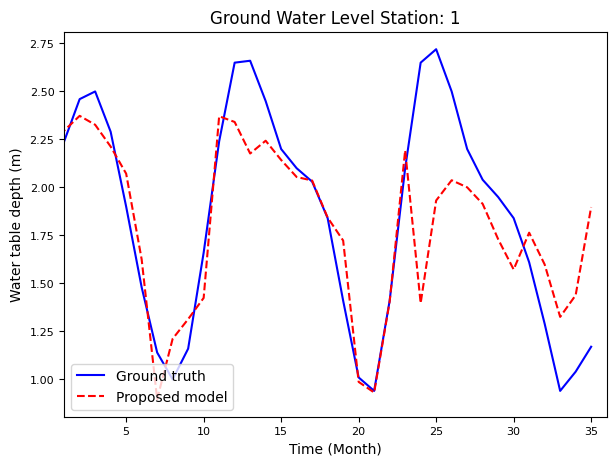

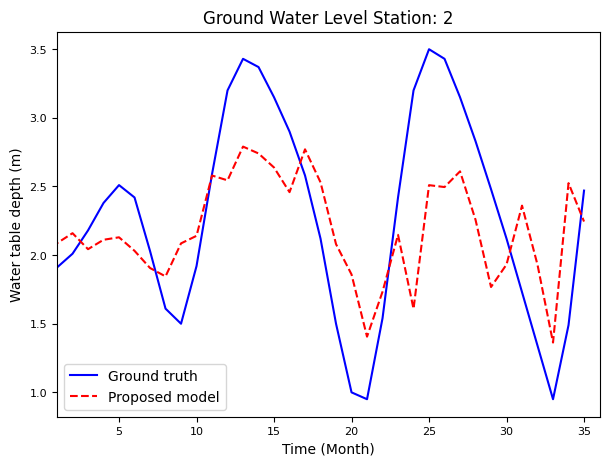

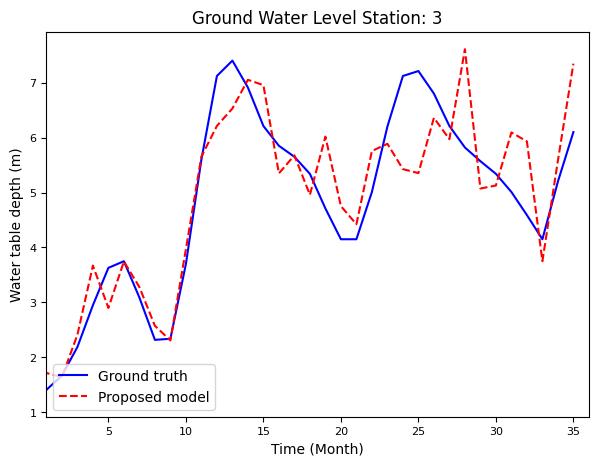

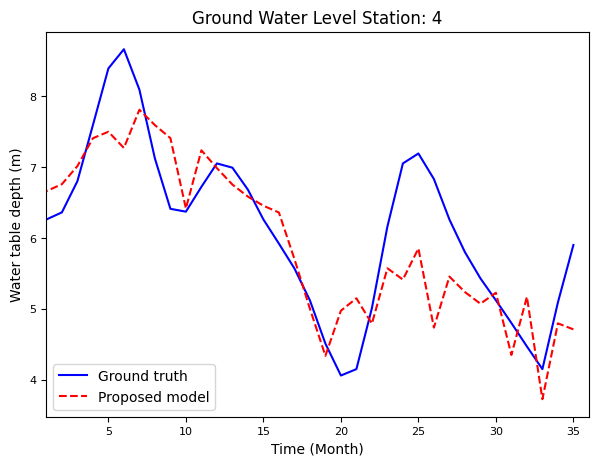

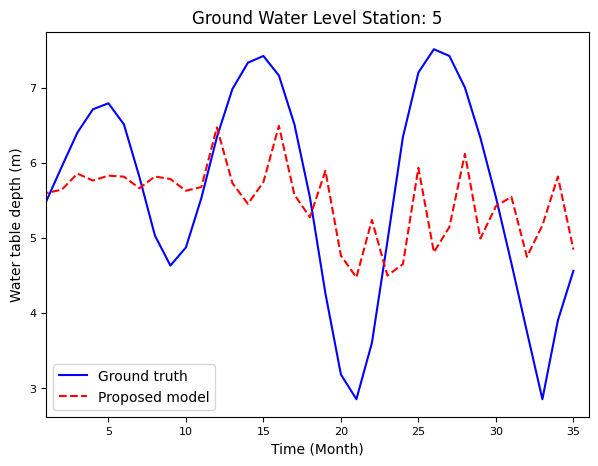

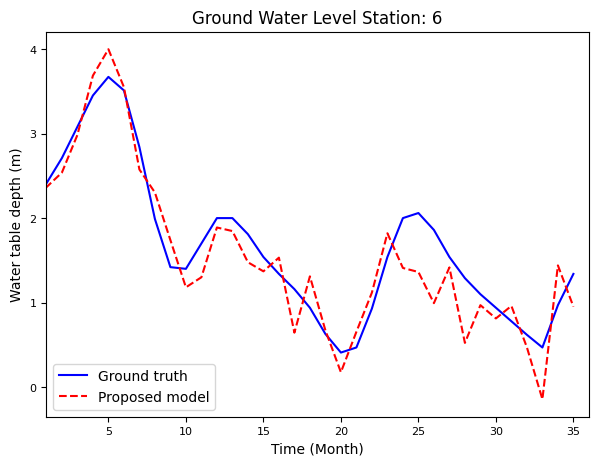

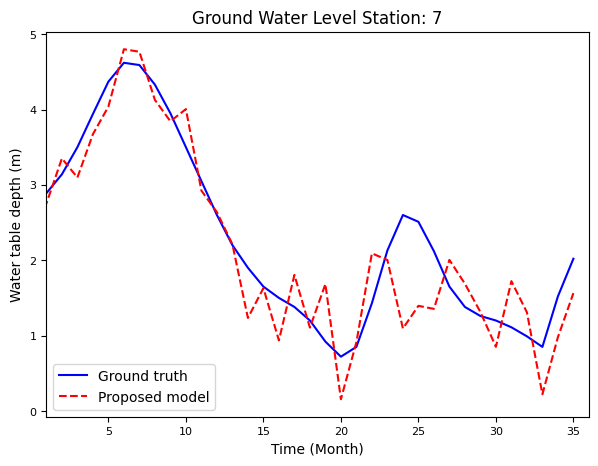

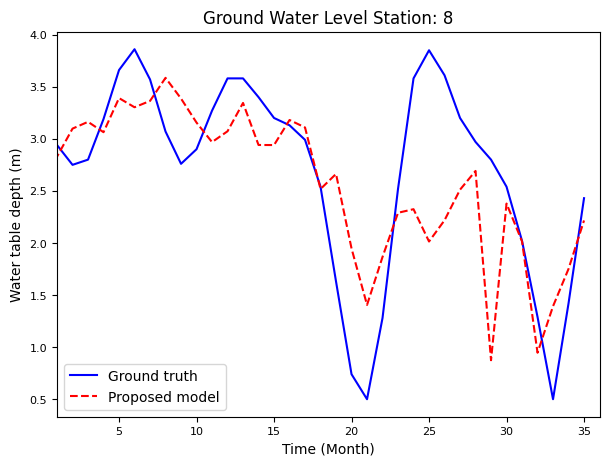

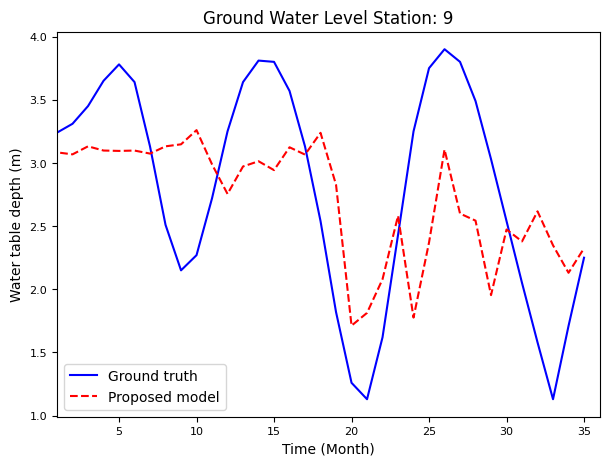

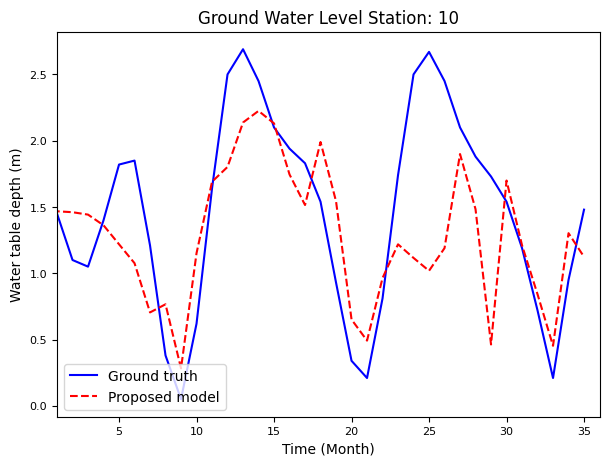

In [ ]:
#Plot prediction graphs for all stations
for i in range(len(y)):
  f, ax1 = plt.subplots(1, 1, sharex=True, figsize=(7, 5))
  ax1.plot(y[i], color="blue", linestyle="-", linewidth=1.5, label="Ground truth")
  ax1.plot(predictions[i], color="red", linestyle="--", linewidth=1.5, label="Proposed model")

  title = 'Ground Water Level Station: ' + str(i+1)
  plt.title(title)
  plt.legend(loc='lower left')
  plt.xticks(fontsize=8,fontweight='normal')
  plt.yticks(fontsize=8,fontweight='normal')
  plt.xlabel('Time (Month)', fontsize=10)
  plt.ylabel('Water table depth (m)', fontsize=10)
  plt.xlim(1, 36)
  fig_path = '/content/drive/MyDrive/Research-groundwater/results/results'+ str(i+1) + '.png'
  plt.savefig(fig_path, format='png')
  plt.show()
  print('\n')

## Prediction Map Generation

In [42]:
def Prediction_Map(month, data):
  gw_predicted = []
  title = ''
  # Coordinates values for groundwater stations
  x = np.array([467832.401523971, 443146.209824458, 429703.107900351, 443574.922195059, 460424.637406987, 456562.664375982, 447331.743024499, 
                447031.108056472, 460232.877577747, 458391.218720615])
  yy = np.array([891596.551703831, 953767.449818275, 931996.140547463, 945237.224654121, 928631.01342047, 912465.915541243, 906365.910660564,
                 902120.902257186, 923617.482967252,901139.622458211])

  # loops through prediction vector and extract monthly groundwater value for each station
  if str(data) == str(predictions):
    for i in range(0,10):
      gw_predicted.append(list(data[i][month]))
      title = 'Groundwater Level Estimate - month: '
  elif str(data) == str(y):
    for i in range(0,10):
      gw_predicted.append(data[i][month])
      title = 'Groundater Level Estimate - Ground Truth Data'

  gw = np.array(gw_predicted)
  # ordinary kriging method
  OK = OrdinaryKriging(x, yy, gw, variogram_model='gaussian',verbose=True, enable_plotting=True, enable_statistics = True,
                       nlags=7, coordinates_type= 'euclidean')
  gridx = np.arange(420000, 490000, 3000, dtype='float64')
  gridy = np.arange(880000, 960000, 3000, dtype='float64')
  zstar, ss = OK.execute("grid", gridx, gridy)
  # Plot Estimation Map
  cax = plt.imshow(zstar, extent=(410000, 490000, 880000, 970000), origin='lower')
  plt.scatter(x, yy, c='k', marker='.')
  cbar=plt.colorbar(cax)
  plt.title(title + str(month))
  plt.xlabel('X')
  plt.ylabel('Y')
  fig_path = '/content/drive/MyDrive/Research-groundwater/results/Prediction_Map_month-(ground truth data)'+ str(month) + '.png'
  plt.savefig(fig_path, format='png')

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 2.582683605172383
Full Sill: 3.1307209245880143
Range: 32731.14512508047
Nugget: 0.5480373194156309 



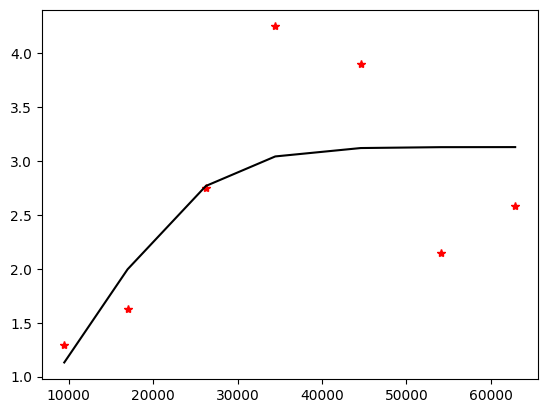

Calculating statistics on variogram model fit...
Q1 = 0.04666901729536977
Q2 = 1.5112934076892766
cR = 3.4400142938525415 

Executing Ordinary Kriging...



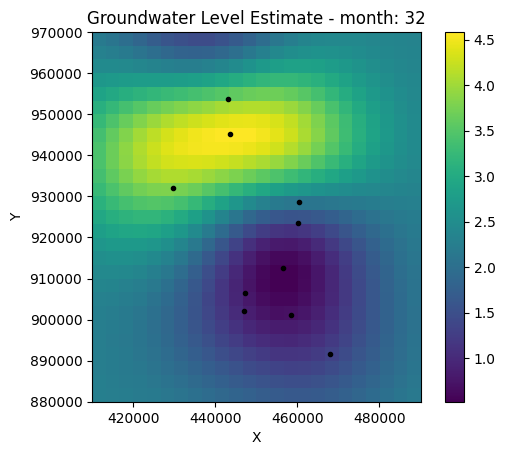

In [43]:
Prediction_Map(month = 32, data = predictions)

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 2.6717248880941553
Full Sill: 2.945964879389161
Range: 37884.457604664516
Nugget: 0.27423999129500565 



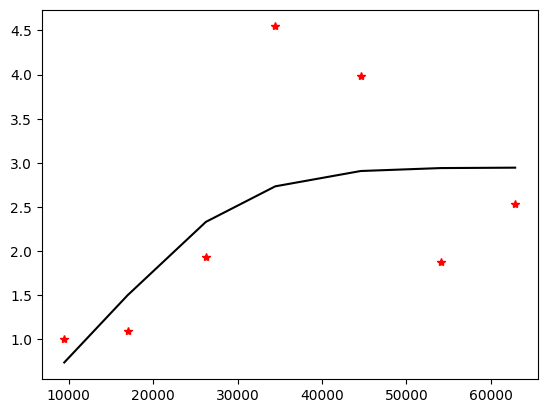

Calculating statistics on variogram model fit...
Q1 = 0.20735056564793256
Q2 = 1.594631086440277
cR = 2.4915205036835824 

Executing Ordinary Kriging...



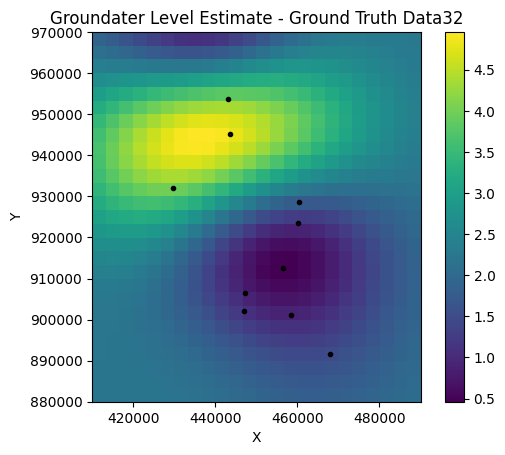

In [44]:
Prediction_Map(month = 32, data = y)